<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/NY_baselineAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

New york state has reduced the Covid-19 cases. We have investigated the mask, social distancing, mobility data for NY state

In [1]:
!pip install wget


  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=661bd401a232b4af7a440f78804cbfefe9ed79a8715bc5dd3cf6108bb1f05009
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import wget
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [98]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

## County Population

In [3]:
US_population_filename = wget.download('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
county_population_US = pd.read_csv(US_population_filename,low_memory=False)
print(county_population_US.shape)

county_population_US.head(2)

(3195, 4)


,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869


In [4]:
ny_population = county_population_US[county_population_US['State'] == 'NY']
print(ny_population.shape)
ny_population.head(2)

(64, 4)


,countyFIPS,County Name,State,population
1861,0,Statewide Unallocated,NY,0
1862,0,New York City Unallocated,NY,0


In [5]:
ny_population['County Name'].unique()

array(['Statewide Unallocated', 'New York City Unallocated',
       'Albany County', 'Allegany County', 'Bronx County',
       'Broome County', 'Cattaraugus County', 'Cayuga County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
       'Delaware County', 'Dutchess County', 'Erie County',
       'Essex County', 'Franklin County', 'Fulton County',
       'Genesee County', 'Greene County', 'Hamilton County',
       'Herkimer County', 'Jefferson County', 'Kings County',
       'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Queens County', 'Rensselaer County',
       'Richmond County', 'Rockland County', 'St. Lawrence County',
       'Sara

In [6]:
queens_county_population = ny_population[ny_population['County Name'] == 'Queens County']
queens_county_population

,countyFIPS,County Name,State,population
1903,36081,Queens County,NY,2253858


## Land Area 

In [7]:
landarea_filename = wget.download('https://raw.githubusercontent.com/ykzeng/covid-19/master/data/census-landarea-all.csv')
landarea_data = pd.read_csv(landarea_filename,low_memory=False)
print(landarea_data.shape)


(3195, 52)


In [8]:
landarea_data.head(2)

,fips,PST045212,PST040210,PST120212,POP010210,AGE135212,AGE295212,AGE775212,SEX255212,RHI125212,RHI225212,RHI325212,RHI425212,RHI525212,RHI625212,RHI725212,RHI825212,POP715211,POP645211,POP815211,EDU635211,EDU685211,VET605211,LFE305211,HSG010211,HSG445211,HSG096211,HSG495211,HSD410211,HSD310211,INC910211,INC110211,PVY020211,BZA010211,BZA110211,BZA115211,NES010211,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030212,LND110210,POP060210
0,0,313914040,308747508,1.7,308745538,6.4,23.5,13.7,50.8,77.9,13.1,1.2,5.1,0.2,2.4,16.9,63.0,84.6,12.8,20.3,85.4,28.2,22215303,25.4,132312404,66.1,25.9,186200,114761359,2.60,27915,52762,14.3,7354043,113425965,1.3,22491080,27092908,7.1,0.9,5.7,0.1,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,829658,3531905.43,87.4
1,1000,4822023,4779745,0.9,4779736,6.3,23.3,14.5,51.5,70.0,26.5,0.7,1.2,0.1,1.5,4.1,66.6,84.5,3.4,5.0,81.9,22.0,403982,24.0,2182088,70.7,15.5,120800,1831269,2.53,23483,42934,17.6,97743,1573138,0.3,321641,382350,14.8,0.8,1.8,0.1,1.2,28.1,112858843,52252752,57344851,12364,6426342,13506,50645.33,94.4


In [9]:
landarea_data['fips'].unique()

array([    0,  1000,  1001, ..., 56041, 56043, 56045])

In [10]:
#LND110210

landarea_data[landarea_data['fips'] == 36081]['LND110210']

1902    108.53
Name: LND110210, dtype: float64

#### Population density

In [22]:
density = 2253858/108.53

density

20767.142725513684

Queens population density

In [11]:
queens_population_density=pd.merge(queens_county_population,landarea_data,how='inner', left_on=['countyFIPS'], right_on = ['fips'])

In [12]:
queens_population_density['population_density']= queens_population_density['population']/queens_population_density['LND110210']
queens_population_density = queens_population_density[['fips','County Name', 'State', 'population','LND110210','population_density']].copy()
queens_population_density.tail(3)

,fips,County Name,State,population,LND110210,population_density
0,36081,Queens County,NY,2253858,108.53,20767.142726


## Mask data

In [13]:
mask_filename = wget.download('https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv')
mask_filename

'mask-use-by-county.csv'

In [14]:

mask_data = pd.read_csv(mask_filename,low_memory=False)
print(mask_data.shape)

(3142, 6)


In [15]:
mask_data.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [16]:
mask_data[mask_data['COUNTYFP'] == 36081]

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1868,36081,0.022,0.023,0.068,0.136,0.751


In [29]:
0.022 +	0.023	+0.068	+0.136+	0.751

1.0

## Mobility Data 

### Google mobility data

In [17]:
google_data_url = 'https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/google_reports/mobility_report_US.csv'

google_filename = wget.download(google_data_url)
google_mobility_data = pd.read_csv(google_filename,low_memory=False)
google_mobility_data.head(2)

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential
0,Total,Total,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,Total,Total,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0


In [18]:
NY_GoogleMobility_data = google_mobility_data[google_mobility_data['state'] == 'New York']
print(NY_GoogleMobility_data.shape)
NY_GoogleMobility_data.tail(2)

(11098, 9)


,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential
284597,New York,Yates County,2020-08-10,NaN,34.0,NaN,NaN,-24.0,NaN
284598,New York,Yates County,2020-08-11,NaN,30.0,NaN,NaN,-24.0,NaN


### Apple mobility data

In [19]:
apple_report_url = 'https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/apple_mobility_report_US.csv'

apple_filename = wget.download(apple_report_url)
apple_mobility_data = pd.read_csv(apple_filename,low_memory=False)
apple_mobility_data.tail(2)

,state,county_and_city,geo_type,date,driving,transit,walking
480526,Wyoming,Uinta County,county,2020-08-13,315.41,NaN,NaN
480527,Wyoming,Uinta County,county,2020-08-14,419.87,NaN,NaN


In [20]:
NY_AppleMobility_data = apple_mobility_data[apple_mobility_data['state'] == 'New York']
print(NY_AppleMobility_data.shape)
NY_AppleMobility_data.tail(2)

(14271, 7)


,state,county_and_city,geo_type,date,driving,transit,walking
277111,New York,Yates County,county,2020-08-13,303.29,NaN,NaN
277112,New York,Yates County,county,2020-08-14,368.57,NaN,NaN


In [21]:
NY_AppleMobility_data['county'] = NY_AppleMobility_data['county_and_city']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
NY_AppleMobility_data = NY_AppleMobility_data[['state','county','date','driving','transit','walking']]

NY_AppleMobility_data.tail(2)

,state,county,date,driving,transit,walking
277111,New York,Yates County,2020-08-13,303.29,NaN,NaN
277112,New York,Yates County,2020-08-14,368.57,NaN,NaN


In [23]:
NY_mobility_data = pd.merge(NY_GoogleMobility_data,NY_AppleMobility_data,how='outer' ,on=['state','county','date'])
NY_mobility_data.shape

(14395, 12)

In [24]:
NY_mobility_data = NY_mobility_data.fillna(0)
NY_mobility_data.tail()

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
14390,New York,Yates County,2020-02-13,0.0,0.0,0.0,0.0,0.0,0.0,30.28,0.0,0.0
14391,New York,Yates County,2020-02-14,0.0,0.0,0.0,0.0,0.0,0.0,78.01,0.0,0.0
14392,New York,Yates County,2020-08-12,0.0,0.0,0.0,0.0,0.0,0.0,290.56,0.0,0.0
14393,New York,Yates County,2020-08-13,0.0,0.0,0.0,0.0,0.0,0.0,303.29,0.0,0.0
14394,New York,Yates County,2020-08-14,0.0,0.0,0.0,0.0,0.0,0.0,368.57,0.0,0.0


### Queens county mobility data

In [25]:
queens_mobility_data = NY_mobility_data[NY_mobility_data['county'] == 'Queens County']
print(queens_mobility_data.shape)
queens_mobility_data.tail()

(215, 12)


,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
13172,New York,Queens County,2020-02-13,0.0,0.0,0.0,0.0,0.0,0.0,14.60,0.0,0.0
13173,New York,Queens County,2020-02-14,0.0,0.0,0.0,0.0,0.0,0.0,34.10,0.0,0.0
13174,New York,Queens County,2020-08-12,0.0,0.0,0.0,0.0,0.0,0.0,26.37,0.0,0.0
13175,New York,Queens County,2020-08-13,0.0,0.0,0.0,0.0,0.0,0.0,26.34,0.0,0.0
13176,New York,Queens County,2020-08-14,0.0,0.0,0.0,0.0,0.0,0.0,48.74,0.0,0.0


In [26]:
queens_mobility_data.head()

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
7160,New York,Queens County,2020-02-15,-2.0,-5.0,-11.0,-5.0,2.0,0.0,15.43,0.0,0.0
7161,New York,Queens County,2020-02-16,1.0,-5.0,5.0,-5.0,-1.0,-1.0,-2.23,0.0,0.0
7162,New York,Queens County,2020-02-17,7.0,0.0,39.0,-16.0,-38.0,10.0,1.85,0.0,0.0
7163,New York,Queens County,2020-02-18,0.0,-4.0,-7.0,-5.0,-9.0,3.0,4.02,0.0,0.0
7164,New York,Queens County,2020-02-19,3.0,-2.0,14.0,-5.0,-9.0,2.0,5.73,0.0,0.0


## Social Distancing metric 

In [27]:
socialdistancing_url = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'

socialdistancing_file = wget.download(socialdistancing_url)
socialdistancing_data = pd.read_csv(socialdistancing_file,low_memory=False)
socialdistancing_data.tail(2)



,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
437898,2020-08-10,US,2,Wyoming,Uinta County,56041.0,699,5.901,188
437899,2020-08-11,US,2,Wyoming,Uinta County,56041.0,722,5.796,185


In [28]:
newyork_socialdistancing_data= socialdistancing_data[(socialdistancing_data['admin1']=='New York') &
                                           (socialdistancing_data['admin_level']== 2)]

newyork_socialdistancing_data.head()

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
254507,2020-03-01,US,2,New York,Albany County,36001.0,4095,2.616,54
254508,2020-03-02,US,2,New York,Albany County,36001.0,4376,4.680,97
254509,2020-03-03,US,2,New York,Albany County,36001.0,4686,4.778,100
254510,2020-03-04,US,2,New York,Albany County,36001.0,4842,4.486,93
254511,2020-03-05,US,2,New York,Albany County,36001.0,4548,5.129,107


In [29]:
queens_social_distancing = newyork_socialdistancing_data[newyork_socialdistancing_data['admin2'] == 'Queens County']
print(queens_social_distancing.shape)
queens_social_distancing.head()

(162, 9)


,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
260825,2020-03-01,US,2,New York,Queens County,36081.0,26218,1.339,35
260826,2020-03-02,US,2,New York,Queens County,36081.0,27435,3.813,99
260827,2020-03-03,US,2,New York,Queens County,36081.0,28459,3.747,98
260828,2020-03-04,US,2,New York,Queens County,36081.0,29480,3.822,99
260829,2020-03-05,US,2,New York,Queens County,36081.0,27602,4.052,106


# Load Data for covid-19 cases

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [44]:
!ls /content/drive/'Shared drives'/'CMPE 295- Master Project'/Covid19-data

CA_Covid-19.csv  queens_all_combined.csv  Queens_county.csv
NY_Covid-19.csv  queens_all_filtered.csv


In [31]:
queens_covidcases = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Queens_county.csv', low_memory =False)
queens_covidcases.tail()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
201,8/5/20,New York,36081.0,0,0,636,29
202,8/6/20,New York,36081.0,0,0,703,2
203,8/7/20,New York,36081.0,0,0,714,4
204,8/8/20,New York,36081.0,0,0,703,8
205,8/9/20,New York,36081.0,0,0,515,6


## Fix Date

In [32]:
def fixDate(x):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  return '20'+y+'-'+m+'-'+d

In [47]:
queens_covidcases['Date'] = queens_covidcases['Date'].apply(lambda x: fixDate(x))
queens_covidcases.reset_index(drop=True)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36081.0,0,0,0,0
1,2020-01-23,New York,36081.0,0,0,0,0
2,2020-01-24,New York,36081.0,0,0,0,0
3,2020-01-25,New York,36081.0,0,0,0,0
4,2020-01-26,New York,36081.0,0,0,0,0
...,...,...,...,...,...,...,...
201,2020-08-05,New York,36081.0,0,0,636,29
202,2020-08-06,New York,36081.0,0,0,703,2
203,2020-08-07,New York,36081.0,0,0,714,4
204,2020-08-08,New York,36081.0,0,0,703,8


# Formula Computation from Baseline Value

## For Social Distancing Metric

In [48]:
start_date = '2020-05-05'
end_date = '2020-05-13'
#start_date = '2020-02-17'
#end_date = '2020-03-07'
mask = (queens_social_distancing['date'] >= start_date) & (queens_social_distancing['date'] <= end_date)

In [49]:
df_queens_social_distancing =  queens_social_distancing.loc[mask]
df_queens_social_distancing

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
260889,2020-05-05,US,2,New York,Queens County,36081.0,26633,0.021,0
260890,2020-05-06,US,2,New York,Queens County,36081.0,27819,0.020,0
260891,2020-05-07,US,2,New York,Queens County,36081.0,29651,0.022,0
260892,2020-05-08,US,2,New York,Queens County,36081.0,27390,0.019,0
260893,2020-05-09,US,2,New York,Queens County,36081.0,27340,0.017,0
260894,2020-05-10,US,2,New York,Queens County,36081.0,27660,0.017,0
260895,2020-05-11,US,2,New York,Queens County,36081.0,27697,0.017,0
260896,2020-05-12,US,2,New York,Queens County,36081.0,29950,0.021,0
260897,2020-05-13,US,2,New York,Queens County,36081.0,28052,0.020,0


In [50]:
queens_social_distancing_base = (
    df_queens_social_distancing
    .pipe(lambda x: x.assign(gains_pctg=x["m50"]))
    .groupby(['admin1','admin2','fips'])
    .agg({"gains_pctg": "median"})
    .reset_index()
    .rename(columns={"gains_pctg": "m50"})
)
queens_social_distancing_base

,admin1,admin2,fips,m50
0,New York,Queens County,36081.0,0.02


In [51]:
queens_social_distancing_base.at[0,'m50']

0.02

computing formula : m50_baseline = 100 * m50/queens_social_distancing_base.at[0,'m50']

In [52]:
socialdistancing_data['m50_baseline'] = socialdistancing_data['m50'].apply(lambda x: 100 * (x/queens_social_distancing_base.at[0,'m50']))


In [53]:
socialdistancing_data[socialdistancing_data['admin1'] == 'California']

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,m50_baseline
26590,2020-03-01,US,1,California,NaN,6.0,451282,4.122,60,20610.0
26591,2020-03-02,US,1,California,NaN,6.0,457175,6.725,98,33625.0
26592,2020-03-03,US,1,California,NaN,6.0,472598,6.842,100,34210.0
26593,2020-03-04,US,1,California,NaN,6.0,481255,6.827,99,34135.0
26594,2020-03-05,US,1,California,NaN,6.0,458159,7.270,106,36350.0
...,...,...,...,...,...,...,...,...,...,...
35425,2020-08-07,US,2,California,Yuba County,6115.0,1260,5.792,61,28960.0
35426,2020-08-08,US,2,California,Yuba County,6115.0,1183,3.720,39,18600.0
35427,2020-08-09,US,2,California,Yuba County,6115.0,1231,1.465,15,7325.0
35428,2020-08-10,US,2,California,Yuba County,6115.0,1297,4.869,51,24345.0


# Rolling Average for Social Distancing

In [54]:
queens_social_distancing = newyork_socialdistancing_data[newyork_socialdistancing_data['admin2'] == 'Queens County']
queens_social_distancing.head(3)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
260825,2020-03-01,US,2,New York,Queens County,36081.0,26218,1.339,35
260826,2020-03-02,US,2,New York,Queens County,36081.0,27435,3.813,99
260827,2020-03-03,US,2,New York,Queens County,36081.0,28459,3.747,98


In [55]:
queens_social_distancing.iloc[:,8]

260825     35
260826     99
260827     98
260828     99
260829    106
         ... 
260982     22
260983     18
260984      5
260985     21
260986     22
Name: m50_index, Length: 162, dtype: int64

In [56]:
import pandas as pd
import altair as alt

base_queens = alt.Chart(queens_social_distancing).mark_bar().encode(
    x='monthdate(date):O',
).properties(
    width=500
)

In [57]:
base_queens.encode(y="m50_index").properties(title='Queens County Social Distancing Mteric(m50_index)')

alt.Chart(...)

In [58]:
queens_social_distancing['rolling_average'] = queens_social_distancing.iloc[:,8].rolling(window=7).mean()

base_queens = alt.Chart(queens_social_distancing).mark_bar().encode(
    x='monthdate(date):O',
).properties(
    width=500
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
queens_social_distancing.tail(10)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,rolling_average
260977,2020-08-02,US,2,New York,Queens County,36081.0,39110,0.062,1,14.000000
260978,2020-08-03,US,2,New York,Queens County,36081.0,39985,0.601,15,14.857143
260979,2020-08-04,US,2,New York,Queens County,36081.0,39689,0.171,4,13.285714
260980,2020-08-05,US,2,New York,Queens County,36081.0,36554,0.906,23,14.285714
260981,2020-08-06,US,2,New York,Queens County,36081.0,40105,0.789,20,14.571429
260982,2020-08-07,US,2,New York,Queens County,36081.0,37762,0.857,22,14.857143
260983,2020-08-08,US,2,New York,Queens County,36081.0,32671,0.714,18,14.714286
260984,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714
260985,2020-08-10,US,2,New York,Queens County,36081.0,36840,0.825,21,16.142857
260986,2020-08-11,US,2,New York,Queens County,36081.0,37263,0.850,22,18.714286


In [60]:
base_queens.encode(y="rolling_average").properties(title='Queens County- 7 day rolling average (Social Distancing Metric)')


alt.Chart(...)

In [61]:
bar = base_queens.mark_bar().encode(y="m50_index")

line =  base_queens.mark_line(color='red').encode(
    y='rolling_average'
)

(bar + line).properties(title='Queens County - Social Distancing Metric and rolling average ',width=600)|base_queens.encode(y="rolling_average").properties(title='Queens County- 7 day rolling average (Social Distancing Metric)')

alt.HConcatChart(...)

## Overlap PLot

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

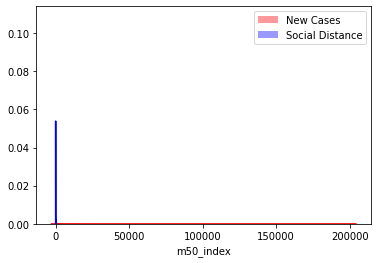

In [63]:
# Method 1: on the same Axis
sns.distplot( queens_covidcases["New cases"] , color="red", label="New Cases")
sns.distplot( (queens_social_distancing["m50_index"]) , color="blue", label="Social Distance")
plt.legend()
 
plt.show()

# Merge Social Distancing and 'New Cases'

In [64]:
merged_socialDistancing = pd.merge(queens_covidcases,queens_social_distancing,how='inner', left_on=['Date'], right_on = ['date'])

In [65]:
merged_socialDistancing.tail()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,rolling_average
157,2020-08-05,New York,36081.0,0,0,636,29,2020-08-05,US,2,New York,Queens County,36081.0,36554,0.906,23,14.285714
158,2020-08-06,New York,36081.0,0,0,703,2,2020-08-06,US,2,New York,Queens County,36081.0,40105,0.789,20,14.571429
159,2020-08-07,New York,36081.0,0,0,714,4,2020-08-07,US,2,New York,Queens County,36081.0,37762,0.857,22,14.857143
160,2020-08-08,New York,36081.0,0,0,703,8,2020-08-08,US,2,New York,Queens County,36081.0,32671,0.714,18,14.714286
161,2020-08-09,New York,36081.0,0,0,515,6,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714


In [66]:
merged_socialDistancing['m50_multiplied'] = merged_socialDistancing['m50_index'] * 1000

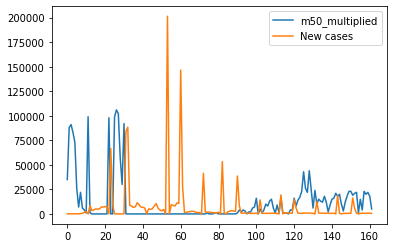

In [67]:
merged_socialDistancing[['m50_multiplied','New cases']].plot()

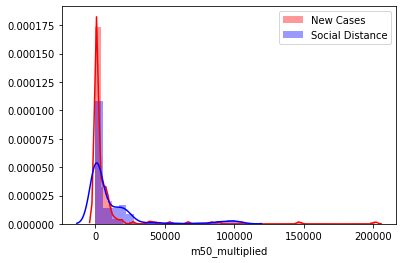

In [68]:
# Method 1: on the same Axis
sns.distplot( merged_socialDistancing["New cases"] , color="red", label="New Cases")
sns.distplot( (merged_socialDistancing["m50_multiplied"]) , color="blue", label="Social Distance")
plt.legend()
 
plt.show()

In [69]:
## Moving avg

merged_socialDistancing['rolling_avg_newcases'] = merged_socialDistancing.iloc[:,5].rolling(window=7).mean() 

In [70]:
merged_socialDistancing['rolling_average_multiplies'] = merged_socialDistancing['rolling_average'] * 1000

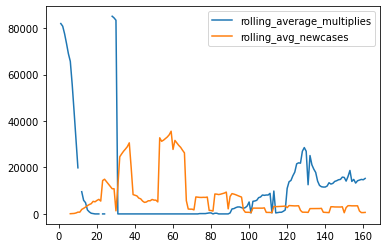

In [71]:
merged_socialDistancing[['rolling_average_multiplies','rolling_avg_newcases']].plot()

## Twin plot

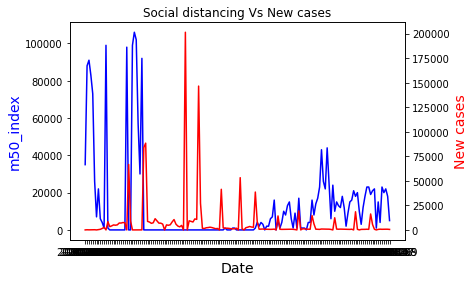

In [72]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_socialDistancing.date, merged_socialDistancing.m50_multiplied, color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("m50_index",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_socialDistancing.date, merged_socialDistancing["New cases"],color="red")
ax2.set_ylabel("New cases",color="red",fontsize=14)
plt.title("Social distancing Vs New cases")

plt.show()

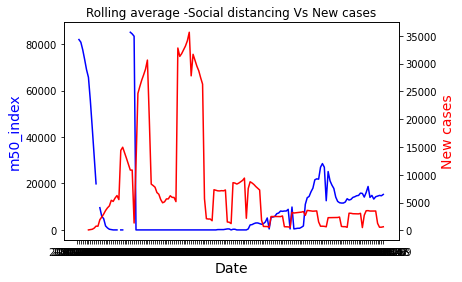

In [73]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_socialDistancing.date, merged_socialDistancing.rolling_average_multiplies, color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("m50_index",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_socialDistancing.date, merged_socialDistancing["rolling_avg_newcases"],color="red")
ax2.set_ylabel("New cases",color="red",fontsize=14)
plt.title("Rolling average -Social distancing Vs New cases")
plt.show()

## Correlation

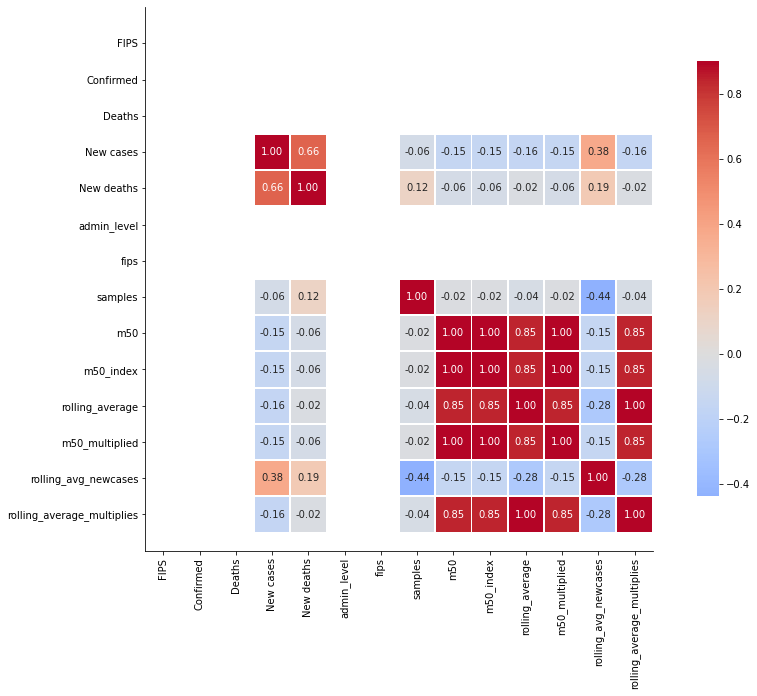

In [74]:
corr = merged_socialDistancing.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=.9, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

# Merge Social Distancing and mobility data

In [75]:
queens_mobility_data.head()

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
7160,New York,Queens County,2020-02-15,-2.0,-5.0,-11.0,-5.0,2.0,0.0,15.43,0.0,0.0
7161,New York,Queens County,2020-02-16,1.0,-5.0,5.0,-5.0,-1.0,-1.0,-2.23,0.0,0.0
7162,New York,Queens County,2020-02-17,7.0,0.0,39.0,-16.0,-38.0,10.0,1.85,0.0,0.0
7163,New York,Queens County,2020-02-18,0.0,-4.0,-7.0,-5.0,-9.0,3.0,4.02,0.0,0.0
7164,New York,Queens County,2020-02-19,3.0,-2.0,14.0,-5.0,-9.0,2.0,5.73,0.0,0.0


In [76]:
queens_covidcases.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36081.0,0,0,0,0
1,2020-01-23,New York,36081.0,0,0,0,0
2,2020-01-24,New York,36081.0,0,0,0,0
3,2020-01-25,New York,36081.0,0,0,0,0
4,2020-01-26,New York,36081.0,0,0,0,0


In [77]:
merged_mobility = pd.merge(queens_covidcases,queens_mobility_data,how='inner', left_on=['Date'], right_on = ['date'])

merged_mobility.head()


,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
0,2020-01-22,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,1.02,0.0,0.0
1,2020-01-23,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,5.10,0.0,0.0
2,2020-01-24,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,19.35,0.0,0.0
3,2020-01-25,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,8.11,0.0,0.0
4,2020-01-26,New York,36081.0,0,0,0,0,New York,Queens County,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,-9.16,0.0,0.0


## Twin plot

### Retail and Recreation Vs new cases

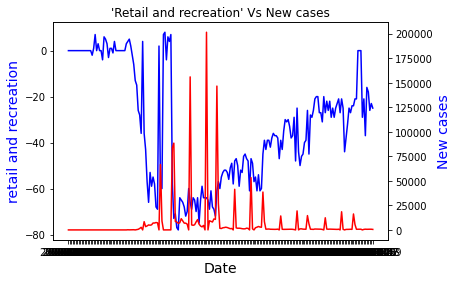

In [78]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['retail and recreation'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("retail and recreation",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'Retail and recreation' Vs New cases")

plt.show()

### Residential Vs New cases

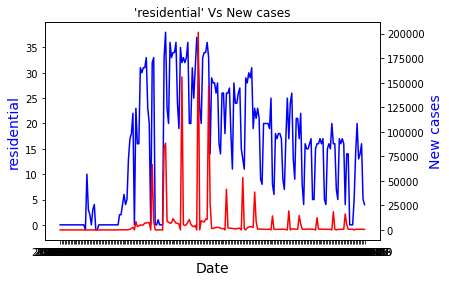

In [79]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['residential'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("residential",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'residential' Vs New cases")

plt.show()

### Workplaces Vs New cases

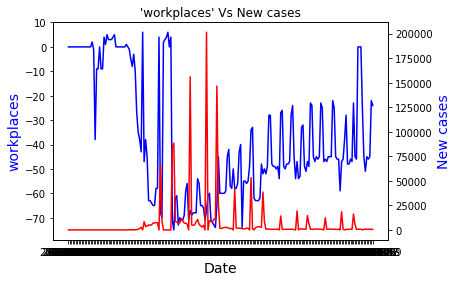

In [80]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['workplaces'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("workplaces",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'workplaces' Vs New cases")

plt.show()

### 'grocery and pharmacy' Vs New Cases

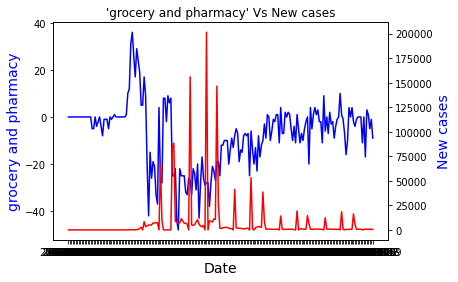

In [81]:


fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['grocery and pharmacy'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("grocery and pharmacy",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'grocery and pharmacy' Vs New cases")

plt.show()

### parks Vs New cases

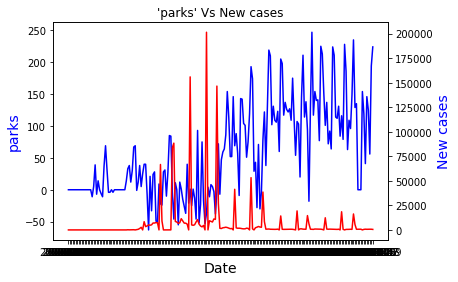

In [82]:

fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['parks'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("parks",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'parks' Vs New cases")

plt.show()

### 'transit stations' Vs New cases

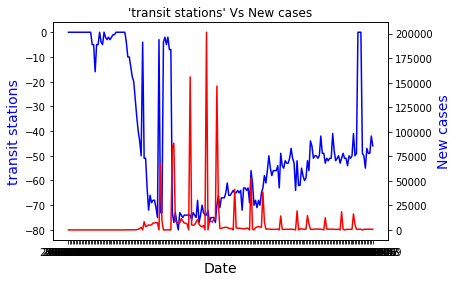

In [83]:

fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['transit stations'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("transit stations",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'transit stations' Vs New cases")

plt.show()

### Driving Vs New cases

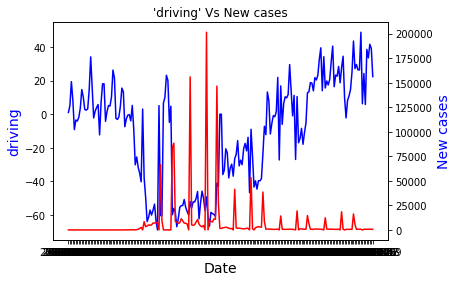

In [84]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['driving'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("driving",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'driving' Vs New cases")

plt.show()

### transit Vs New cases

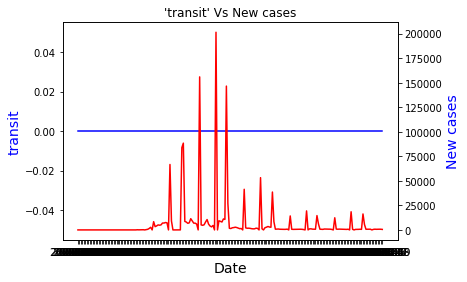

In [85]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['transit'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("transit",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'transit' Vs New cases")

plt.show()

### walking Vs New cases

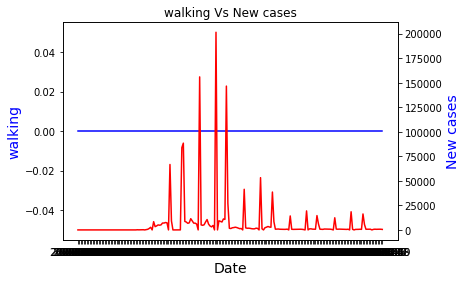

In [86]:
fig,ax = plt.subplots()
# make a plot
ax.plot(merged_mobility.date, merged_mobility['walking'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("walking",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(merged_mobility.date, merged_mobility["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("walking Vs New cases")

plt.show()

# Merge Social Distancing, mobility data and Covid Cases

In [87]:
merged_mobility.tail(1)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
205,2020-08-09,New York,36081.0,0,0,515,6,New York,Queens County,2020-08-09,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0


In [88]:
merged_mobility_social_covid=pd.merge(merged_mobility,queens_social_distancing,how='inner', left_on=['Date','county'], right_on = ['date','admin2'])

In [89]:
merged_mobility_social_covid.tail(3)


,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,date_y,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index,rolling_average
159,2020-08-07,New York,36081.0,0,0,714,4,New York,Queens County,2020-08-07,-26.0,-5.0,56.0,-49.0,-45.0,16.0,41.58,0.0,0.0,2020-08-07,US,2,New York,Queens County,36081.0,37762,0.857,22,14.857143
160,2020-08-08,New York,36081.0,0,0,703,8,New York,Queens County,2020-08-08,-23.0,-1.0,194.0,-42.0,-22.0,5.0,39.14,0.0,0.0,2020-08-08,US,2,New York,Queens County,36081.0,32671,0.714,18,14.714286
161,2020-08-09,New York,36081.0,0,0,515,6,New York,Queens County,2020-08-09,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714


# Merge Social Distancing, mobility data, Covid Cases, Population Density

In [90]:
queens_population_density

,fips,County Name,State,population,LND110210,population_density
0,36081,Queens County,NY,2253858,108.53,20767.142726


In [91]:
merged_mobility_social_covid = pd.merge(merged_mobility_social_covid,queens_population_density,how='inner', left_on=['county'], right_on = ['County Name'])

In [92]:
merged_mobility_social_covid.tail(1)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,date_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,date_y,country_code,admin_level,admin1,admin2,fips_x,samples,m50,m50_index,rolling_average,fips_y,County Name,State,population,LND110210,population_density
161,2020-08-09,New York,36081.0,0,0,515,6,New York,Queens County,2020-08-09,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0,2020-08-09,US,2,New York,Queens County,36081.0,33830,0.221,5,15.285714,36081,Queens County,NY,2253858,108.53,20767.142726


Drop extra columns

In [93]:
column = ['Province_State','date_x','date_y','country_code','admin_level','admin1','admin2','fips_x','County Name','State','population','LND110210']
merged_mobility_social_covid = merged_mobility_social_covid.drop(column, axis = 1)

In [94]:
merged_mobility_social_covid.tail(3)

,Date,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,samples,m50,m50_index,rolling_average,fips_y,population_density
159,2020-08-07,36081.0,0,0,714,4,New York,Queens County,-26.0,-5.0,56.0,-49.0,-45.0,16.0,41.58,0.0,0.0,37762,0.857,22,14.857143,36081,20767.142726
160,2020-08-08,36081.0,0,0,703,8,New York,Queens County,-23.0,-1.0,194.0,-42.0,-22.0,5.0,39.14,0.0,0.0,32671,0.714,18,14.714286,36081,20767.142726
161,2020-08-09,36081.0,0,0,515,6,New York,Queens County,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0,33830,0.221,5,15.285714,36081,20767.142726


# Merge Social Distancing, mobility data, Covid Cases, Population Density and Mask data

In [95]:
# mask data for queens
mask_data[mask_data['COUNTYFP'] == 36081]

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1868,36081,0.022,0.023,0.068,0.136,0.751


In [96]:
merged_mobility_social_covid_mask = pd.merge(merged_mobility_social_covid,mask_data,how='inner', left_on=['fips_y'], right_on = ['COUNTYFP'])

In [97]:
merged_mobility_social_covid_mask.tail(3)

,Date,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,samples,m50,m50_index,rolling_average,fips_y,population_density,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
159,2020-08-07,36081.0,0,0,714,4,New York,Queens County,-26.0,-5.0,56.0,-49.0,-45.0,16.0,41.58,0.0,0.0,37762,0.857,22,14.857143,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
160,2020-08-08,36081.0,0,0,703,8,New York,Queens County,-23.0,-1.0,194.0,-42.0,-22.0,5.0,39.14,0.0,0.0,32671,0.714,18,14.714286,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
161,2020-08-09,36081.0,0,0,515,6,New York,Queens County,-25.0,-9.0,224.0,-46.0,-24.0,4.0,22.34,0.0,0.0,33830,0.221,5,15.285714,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751


In [98]:
# assiging to a datafrmae
queens_all_combined = merged_mobility_social_covid_mask

In [99]:
queens_all_combined.to_csv("queens_all_combined.csv",index=False)

## Correlation plot

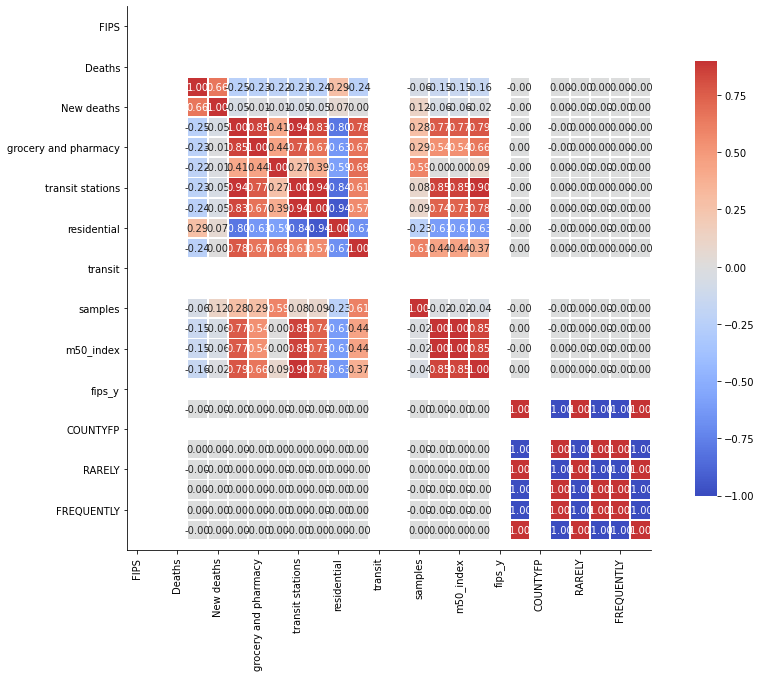

In [100]:
corr = queens_all_combined.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=.9, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

In [101]:
queens_all_combined.head()

,Date,FIPS,Confirmed,Deaths,New cases,New deaths,state,county,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,samples,m50,m50_index,rolling_average,fips_y,population_density,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,2020-03-01,36081.0,0,0,0,0,New York,Queens County,3.0,1.0,14.0,-4.0,1.0,0.0,-2.82,0.0,0.0,26218,1.339,35,NaN,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
1,2020-03-10,36081.0,0,0,150,0,New York,Queens County,4.0,10.0,33.0,-10.0,0.0,2.0,-0.55,0.0,0.0,28607,3.375,88,82.000000,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
2,2020-03-11,36081.0,0,0,70,1,New York,Queens County,5.0,12.0,38.0,-10.0,-1.0,2.0,-0.25,0.0,0.0,28585,3.495,91,80.857143,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
3,2020-03-12,36081.0,0,0,107,0,New York,Queens County,2.0,31.0,12.0,-14.0,-5.0,4.0,-3.93,0.0,0.0,28488,3.193,83,77.571429,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751
4,2020-03-13,36081.0,0,0,94,1,New York,Queens County,-2.0,36.0,30.0,-18.0,-8.0,6.0,5.21,0.0,0.0,27467,2.816,73,73.428571,36081,20767.142726,36081,0.022,0.023,0.068,0.136,0.751


In [102]:
columns = ['Date','FIPS','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','rolling_average','population_density','ALWAYS','New cases']
queens_all_filtered = queens_all_combined[columns]


In [103]:
queens_all_filtered.head()

,Date,FIPS,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,rolling_average,population_density,ALWAYS,New cases
0,2020-03-01,36081.0,3.0,1.0,14.0,-4.0,1.0,0.0,-2.82,1.339,35,NaN,20767.142726,0.751,0
1,2020-03-10,36081.0,4.0,10.0,33.0,-10.0,0.0,2.0,-0.55,3.375,88,82.000000,20767.142726,0.751,150
2,2020-03-11,36081.0,5.0,12.0,38.0,-10.0,-1.0,2.0,-0.25,3.495,91,80.857143,20767.142726,0.751,70
3,2020-03-12,36081.0,2.0,31.0,12.0,-14.0,-5.0,4.0,-3.93,3.193,83,77.571429,20767.142726,0.751,107
4,2020-03-13,36081.0,-2.0,36.0,30.0,-18.0,-8.0,6.0,5.21,2.816,73,73.428571,20767.142726,0.751,94


In [104]:
queens_all_filtered.to_csv('queens_all_filtered.csv',index=False)

## Pending work

- merged_socialDistancing and merged_mobility to be concatenated (done)
- add population and population density as two columns (done)
- mask as one column (done)
- In the final merged dataframe, try gini-index, PCA to determine the key features
- final modeling V1

- Overlap m50 with covid cases 
- Mask data doesn't have time series ; Take the value 
- Mobility data- 8 diff types of data; walking =0; workplace- high; residential - high-> plot

## Loading NY -county data 

In [33]:
NY_covidcases = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_Covid-19.csv', low_memory =False)
NY_covidcases.tail()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
13179,8/9/20,New York,36119.0,36205,1447,515,6
13180,8/9/20,New York,36121.0,118,5,515,6
13181,8/9/20,New York,36123.0,57,7,515,6
13182,8/9/20,New York,80036.0,0,0,515,6
13183,8/9/20,New York,90036.0,0,0,515,6


In [34]:
NY_covidcases['Date'] = NY_covidcases['Date'].apply(lambda x: fixDate(x))
NY_covidcases.reset_index(drop=True)
NY_covidcases.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36001.0,0,0,0,0
1,2020-01-22,New York,36003.0,0,0,0,0


In [35]:
NY_covidcases['FIPS'] = NY_covidcases['FIPS'].apply(lambda x :int(x))

In [36]:
NY_covidcases.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,New York,36001,0,0,0,0
1,2020-01-22,New York,36003,0,0,0,0


In [46]:
NY_covidcases.shape

(13184, 7)

## Combining mask data -NY county

In [37]:
#Mask
NY_mask = pd.merge(NY_covidcases,mask_data,how='inner',left_on=['FIPS'],right_on=['COUNTYFP'])
NY_mask.head(2)


,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,2020-01-22,New York,36001,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788
1,2020-01-23,New York,36001,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788


In [47]:
NY_mask.shape

(12772, 13)

## Combining population density data

In [51]:
# Pop density
#landarea_data[landarea_data['fips'] == 36081]['LND110210']

NY_landarea_df = pd.merge(NY_mask,landarea_data,how='inner',left_on=['FIPS'],right_on=['fips'])
NY_landarea_df.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,fips,PST045212,PST040210,PST120212,POP010210,AGE135212,AGE295212,AGE775212,SEX255212,RHI125212,RHI225212,RHI325212,RHI425212,RHI525212,RHI625212,RHI725212,RHI825212,POP715211,POP645211,POP815211,EDU635211,EDU685211,VET605211,LFE305211,HSG010211,HSG445211,HSG096211,HSG495211,HSD410211,HSD310211,INC910211,INC110211,PVY020211,BZA010211,BZA110211,BZA115211,NES010211,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030212,LND110210,POP060210
0,2020-01-22,New York,36001,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,36001,305455,304206,0.4,304204,4.9,19.2,14.6,51.7,78.6,13.4,0.3,5.3,0.1,2.4,5.3,75.1,84.5,8.9,12.0,91.1,37.8,20729,19.9,138165,59.5,43.1,207300,123544,2.31,31728,57715,12.8,9436,168868,0.6,17635,24798,0.0,0.0,0.0,0.0,2.2,29.9,3351466,3642573,5404372,18121,738926,461,522.8,581.9
1,2020-01-23,New York,36001,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,36001,305455,304206,0.4,304204,4.9,19.2,14.6,51.7,78.6,13.4,0.3,5.3,0.1,2.4,5.3,75.1,84.5,8.9,12.0,91.1,37.8,20729,19.9,138165,59.5,43.1,207300,123544,2.31,31728,57715,12.8,9436,168868,0.6,17635,24798,0.0,0.0,0.0,0.0,2.2,29.9,3351466,3642573,5404372,18121,738926,461,522.8,581.9


In [52]:
NY_landarea_df.shape

(12772, 65)

In [53]:
NY_landarea = pd.merge(NY_landarea_df,ny_population,how='inner',left_on=['FIPS'],right_on=['countyFIPS'])

NY_landarea.head(2)

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,fips,PST045212,PST040210,PST120212,POP010210,AGE135212,AGE295212,AGE775212,SEX255212,RHI125212,RHI225212,RHI325212,RHI425212,RHI525212,RHI625212,RHI725212,RHI825212,POP715211,POP645211,POP815211,EDU635211,EDU685211,VET605211,LFE305211,HSG010211,HSG445211,HSG096211,HSG495211,HSD410211,HSD310211,INC910211,INC110211,PVY020211,BZA010211,BZA110211,BZA115211,NES010211,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030212,LND110210,POP060210,countyFIPS,County Name,State,population
0,2020-01-22,New York,36001,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,36001,305455,304206,0.4,304204,4.9,19.2,14.6,51.7,78.6,13.4,0.3,5.3,0.1,2.4,5.3,75.1,84.5,8.9,12.0,91.1,37.8,20729,19.9,138165,59.5,43.1,207300,123544,2.31,31728,57715,12.8,9436,168868,0.6,17635,24798,0.0,0.0,0.0,0.0,2.2,29.9,3351466,3642573,5404372,18121,738926,461,522.8,581.9,36001,Albany County,NY,305506
1,2020-01-23,New York,36001,0,0,0,0,36001,0.006,0.012,0.052,0.142,0.788,36001,305455,304206,0.4,304204,4.9,19.2,14.6,51.7,78.6,13.4,0.3,5.3,0.1,2.4,5.3,75.1,84.5,8.9,12.0,91.1,37.8,20729,19.9,138165,59.5,43.1,207300,123544,2.31,31728,57715,12.8,9436,168868,0.6,17635,24798,0.0,0.0,0.0,0.0,2.2,29.9,3351466,3642573,5404372,18121,738926,461,522.8,581.9,36001,Albany County,NY,305506


In [56]:
NY_landarea.shape

(12772, 9)

In [55]:
NY_landarea['population_density']= NY_landarea['population']/NY_landarea['LND110210']
NY_landarea = NY_landarea[['Date','fips','New cases','County Name','State','ALWAYS',  'population','LND110210','population_density']].copy()
NY_landarea.tail(3)

,Date,fips,New cases,County Name,State,ALWAYS,population,LND110210,population_density
12769,2020-08-07,36123,714,Yates County,NY,0.884,24913,338.14,73.676584
12770,2020-08-08,36123,703,Yates County,NY,0.884,24913,338.14,73.676584
12771,2020-08-09,36123,515,Yates County,NY,0.884,24913,338.14,73.676584


## Combining mobility data 

In [41]:
# Mobility 
NY_mobility_data.head(2)

,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
0,New York,Total,2020-02-15,3.0,-4.0,-2.0,-4.0,1.0,0.0,25.10,0.0,0.0
1,New York,Total,2020-02-16,7.0,-3.0,13.0,0.0,0.0,-1.0,2.57,0.0,0.0


In [50]:
NY_mobility_combined.shape

(2701690, 20)

In [57]:
NY_mobility_combined = pd.merge(NY_landarea,NY_mobility_data,how='inner',left_on=['Date','County Name'],right_on=['date','county'])
NY_mobility_combined.head(2)

,Date,fips,New cases,County Name,State,ALWAYS,population,LND110210,population_density,state,county,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking
0,2020-01-22,36001,0,Albany County,NY,0.788,305506,522.8,584.364958,New York,Albany County,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,8.37,0.0,0.0
1,2020-01-23,36001,0,Albany County,NY,0.788,305506,522.8,584.364958,New York,Albany County,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,15.09,0.0,0.0


In [58]:
NY_mobility_combined.shape

(12566, 21)

## Combining social distancing 

In [43]:
newyork_socialdistancing_data.head(2)

,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
254507,2020-03-01,US,2,New York,Albany County,36001.0,4095,2.616,54
254508,2020-03-02,US,2,New York,Albany County,36001.0,4376,4.680,97


In [44]:
newyork_socialdistancing_data['fips'] = newyork_socialdistancing_data['fips'].apply(lambda x:int(x))
newyork_socialdistancing_data.tail(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,country_code,admin_level,admin1,admin2,fips,samples,m50,m50_index
264387,2020-08-10,US,2,New York,Yates County,36123,738,6.890,99
264388,2020-08-11,US,2,New York,Yates County,36123,686,5.338,76


In [59]:
NY_mobility_combined.shape

(12566, 21)

In [62]:
NY_socialDistancing_combined = pd.merge(NY_mobility_combined,newyork_socialdistancing_data,how='inner',left_on=['Date','County Name'],right_on=['date','admin2'])
NY_socialDistancing_combined.head(2)

,Date,fips_x,New cases,County Name,State,ALWAYS,population,LND110210,population_density,state,county,date_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,transit,walking,date_y,country_code,admin_level,admin1,admin2,fips_y,samples,m50,m50_index
0,2020-03-01,36001,0,Albany County,NY,0.788,305506,522.8,584.364958,New York,Albany County,2020-03-01,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,0.0,0.0,2020-03-01,US,2,New York,Albany County,36001,4095,2.616,54
1,2020-03-10,36001,150,Albany County,NY,0.788,305506,522.8,584.364958,New York,Albany County,2020-03-10,0.0,9.0,-2.0,0.0,2.0,1.0,5.71,0.0,0.0,2020-03-10,US,2,New York,Albany County,36001,4524,4.672,97


In [63]:
NY_socialDistancing_combined.shape

(9720, 30)

## Filtering columns for feature selection

In [66]:
columns = ['Date','fips_x','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','ALWAYS','New cases']
NY_All_combined = NY_socialDistancing_combined[columns]

NY_All_combined.head(2)


,Date,fips_x,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,ALWAYS,New cases
0,2020-03-01,36001,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0.788,0
1,2020-03-10,36001,0.0,9.0,-2.0,0.0,2.0,1.0,5.71,4.672,97,584.364958,0.788,150


In [67]:
NY_All_combined.shape

(9720, 14)

# Feature Selection - Weightage

### Gini index

In [68]:
NY_All_combined = NY_All_combined.fillna(0)

In [69]:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

In [72]:
# Calling gini-index method

feature_cols=['fips_x','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','ALWAYS']
gini_values = {}
for col in feature_cols:
  dataset = NY_All_combined[col].values.tolist()
  #print(dataset)
  value = gini(dataset)
  print('cols ',col,' - gini coeff is :',value)
  gini_values[col] = value

cols  fips_x  - gini coeff is : 0.0005682138536037098
cols  retail and recreation  - gini coeff is : -0.733657801793567
cols  grocery and pharmacy  - gini coeff is : 3.0509342607868226
cols  parks  - gini coeff is : 1.0498059562095894
cols  transit stations  - gini coeff is : -0.8324378329016143
cols  workplaces  - gini coeff is : -0.32627004105687246
cols  residential  - gini coeff is : 0.5253782351205079
cols  driving  - gini coeff is : 1.1272009935512561
cols  m50  - gini coeff is : 0.4590612933600618
cols  m50_index  - gini coeff is : 0.454313170481218
cols  population_density  - gini coeff is : 0.9079166306993701
cols  ALWAYS  - gini coeff is : 0.04028002560726182


In [73]:
sorted_x = sorted(gini_values.items(), key=lambda kv: kv[1])
sorted_x

[('transit stations', -0.8324378329016143),
 ('retail and recreation', -0.733657801793567),
 ('workplaces', -0.32627004105687246),
 ('fips_x', 0.0005682138536037098),
 ('ALWAYS', 0.04028002560726182),
 ('m50_index', 0.454313170481218),
 ('m50', 0.4590612933600618),
 ('residential', 0.5253782351205079),
 ('population_density', 0.9079166306993701),
 ('parks', 1.0498059562095894),
 ('driving', 1.1272009935512561),
 ('grocery and pharmacy', 3.0509342607868226)]

## Random Forest - Feature selection

In [ ]:
queens_all_combined.describe().T

In [74]:
X_cols = ['fips_x','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','ALWAYS']
Y_cols = ['New cases']

In [76]:
x_train_c = NY_All_combined[X_cols]
y_train_c = NY_All_combined[Y_cols]

In [ ]:
x_train_c

In [77]:
from sklearn.ensemble import RandomForestClassifier

# create the random forest with your hyperparameters.
rfc = RandomForestClassifier(n_estimators=150)

# fit the model to start training.
rfc.fit(x_train_c, y_train_c)

# get the importance of the resulting features.
f_importances = rfc.feature_importances_

# create a data frame for visualization.
final_df = pd.DataFrame({"Features": x_train_c.columns, "Importances":f_importances})

final_df.sort_values('Importances', ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


,Features,Importances
7,driving,0.147758
5,workplaces,0.119227
8,m50,0.112816
2,grocery and pharmacy,0.105266
9,m50_index,0.103070
1,retail and recreation,0.099582
6,residential,0.070755
10,population_density,0.061112
4,transit stations,0.048488
11,ALWAYS,0.046720


## Decision tree- feature selection

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

clf = DecisionTreeClassifier()
clf = clf.fit(x_train_c, y_train_c)
f=clf.feature_importances_

final_dfs = pd.DataFrame({"Features": x_train_c.columns, "Importances":f})

final_dfs.sort_values('Importances', ascending=False)

,Features,Importances
7,driving,0.164125
5,workplaces,0.113907
2,grocery and pharmacy,0.113099
9,m50_index,0.112483
8,m50,0.111645
1,retail and recreation,0.101803
6,residential,0.073467
10,population_density,0.056064
11,ALWAYS,0.042818
4,transit stations,0.039731


## AutoML Implementation

In [100]:
X_cols = ['fips_x','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','ALWAYS']


In [80]:
NY_All_combined['Date'] =  pd.to_datetime(NY_All_combined['Date'])

In [81]:
NY_All_combined.dtypes

Date                     datetime64[ns]
fips_x                            int64
retail and recreation           float64
grocery and pharmacy            float64
parks                           float64
transit stations                float64
workplaces                      float64
residential                     float64
driving                         float64
m50                             float64
m50_index                         int64
population_density              float64
ALWAYS                          float64
New cases                         int64
dtype: object

In [101]:
X = NY_All_combined[X_cols]
Y = NY_All_combined[['New cases']]
Y.shape

(9720, 1)

In [102]:
X_train,X_test,Y_train, Y_test = train_test_split(X, Y,test_size=0.2, random_state=1)

In [103]:
num_folds = 12
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

In [96]:
Y_train.shape

(7776, 1)

In [104]:
results = []
names = []

for name, model in models:
    clf = model
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    accu_score = accuracy_score(Y_test, Y_pred)
    print(name + ": " + str(accu_score))

LR: 0.11162551440329219
LDA: 0.15123456790123457
KNN: 0.07047325102880658
CART: 0.19598765432098766
NB: 0.147119341563786
SVM: 0.11008230452674897
RF: 0.23251028806584362
XGBoost: 0.2602880658436214


# Reference 

* https://medium.com/next-gen-machine-learning/feature-selection-best-methods-for-feature-selection-python-f3536aad5b4a